<h1>Backtest common trading strategies</h1>

In [179]:
%pip install backtrader
%matplotlib inline

import matplotlib.pyplot as plt
import backtrader as bt
import uts

utils = uts.Utilities(is_test=uts.IS_TEST, test_num=uts.TEST_NUM)
etf_dfs = utils.get_dataframes('data/ETFs')
stock_dfs = utils.get_dataframes('data/Stocks') 

STOP_LOSS_PCT = 0.05
TAKE_PROFIT_PCT = 0.1


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
HEEE
HEEE


<IPython.core.display.Javascript object>

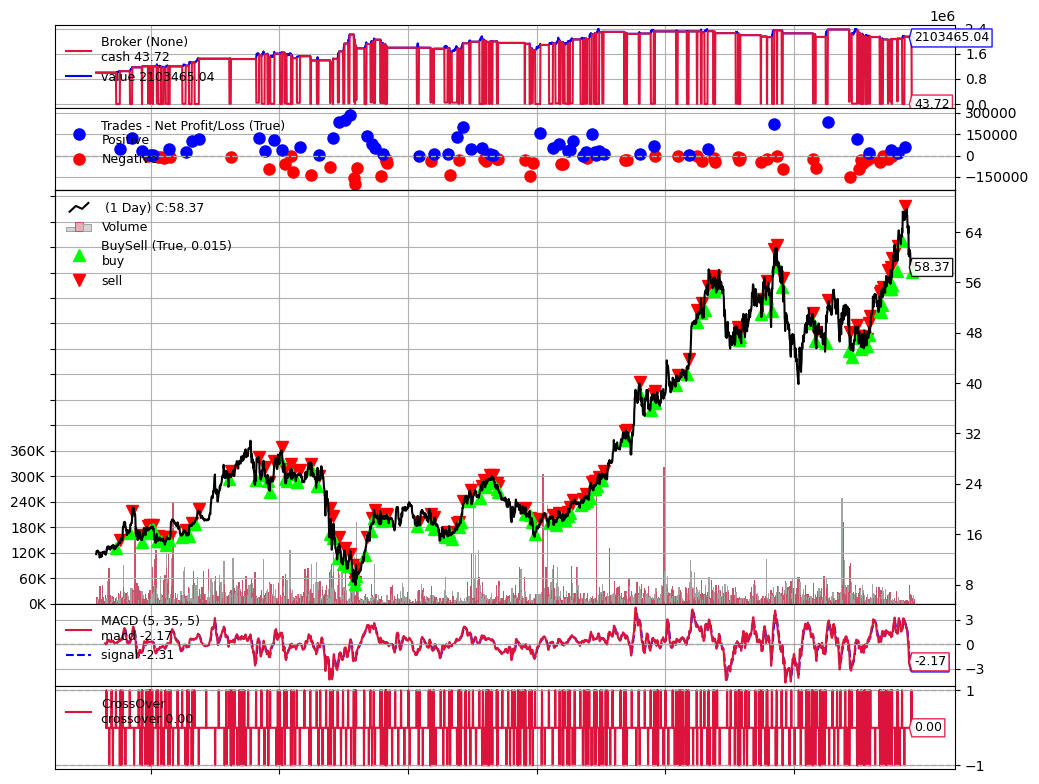

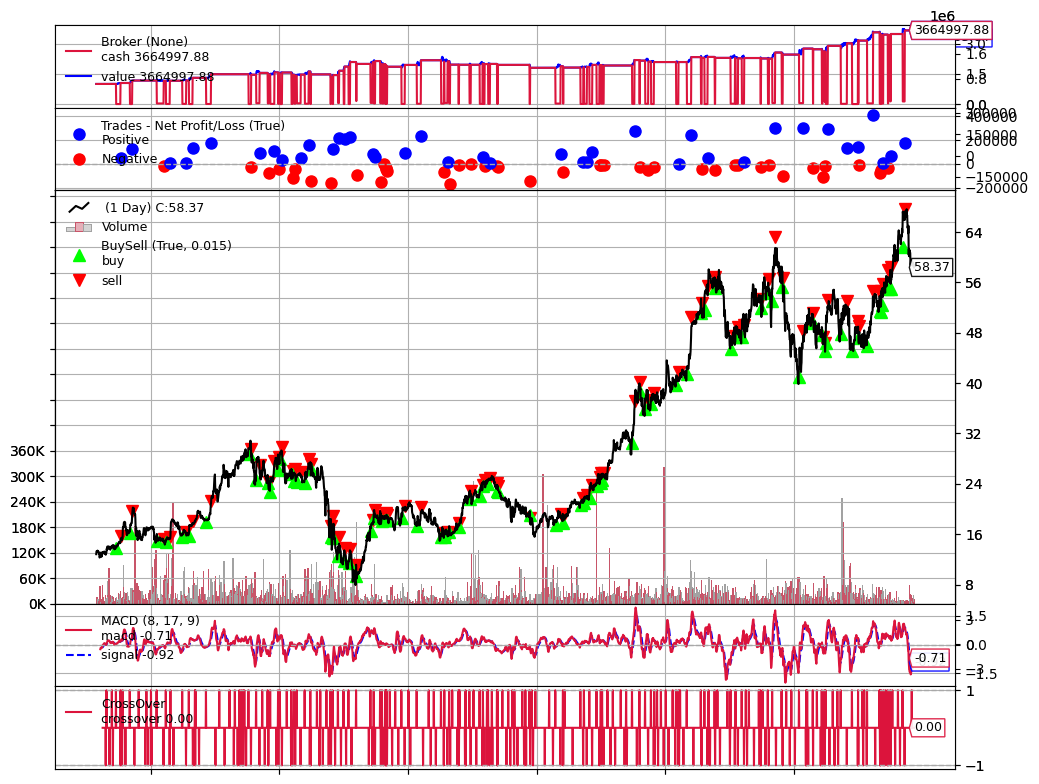

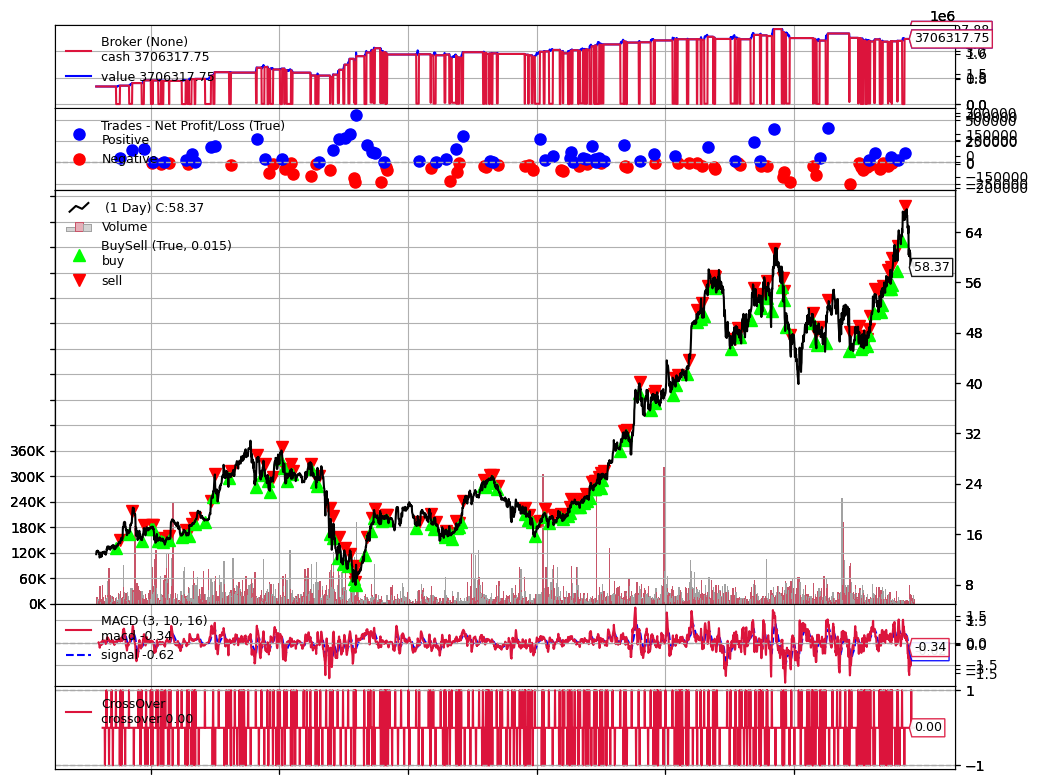

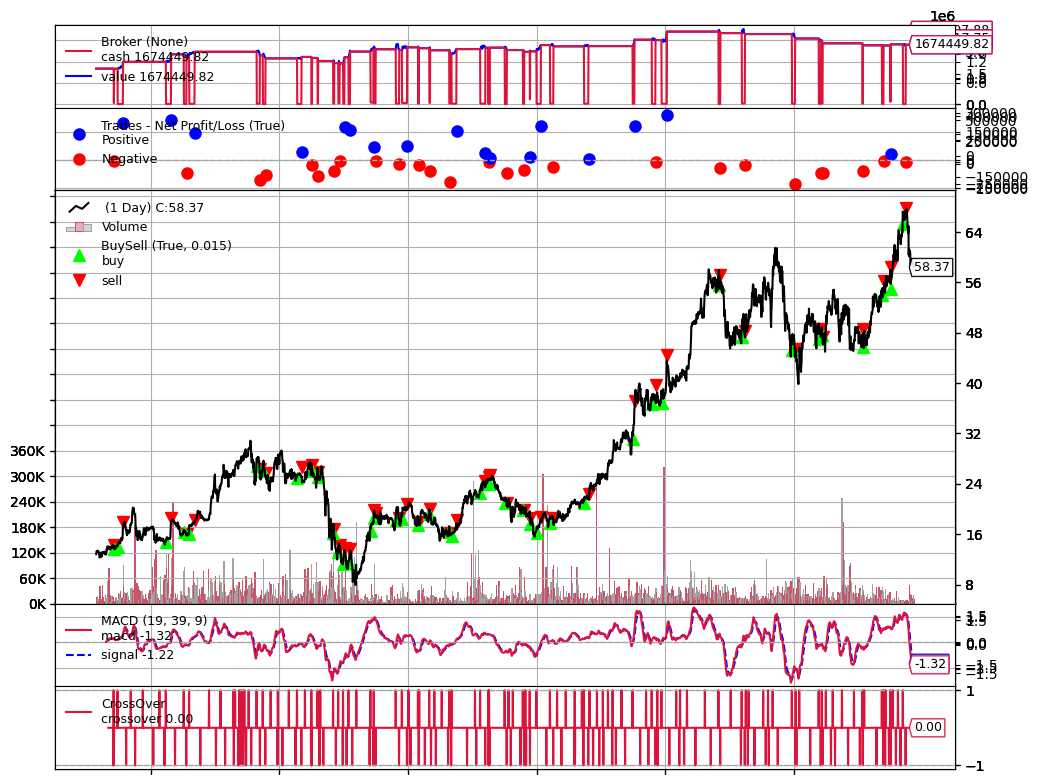

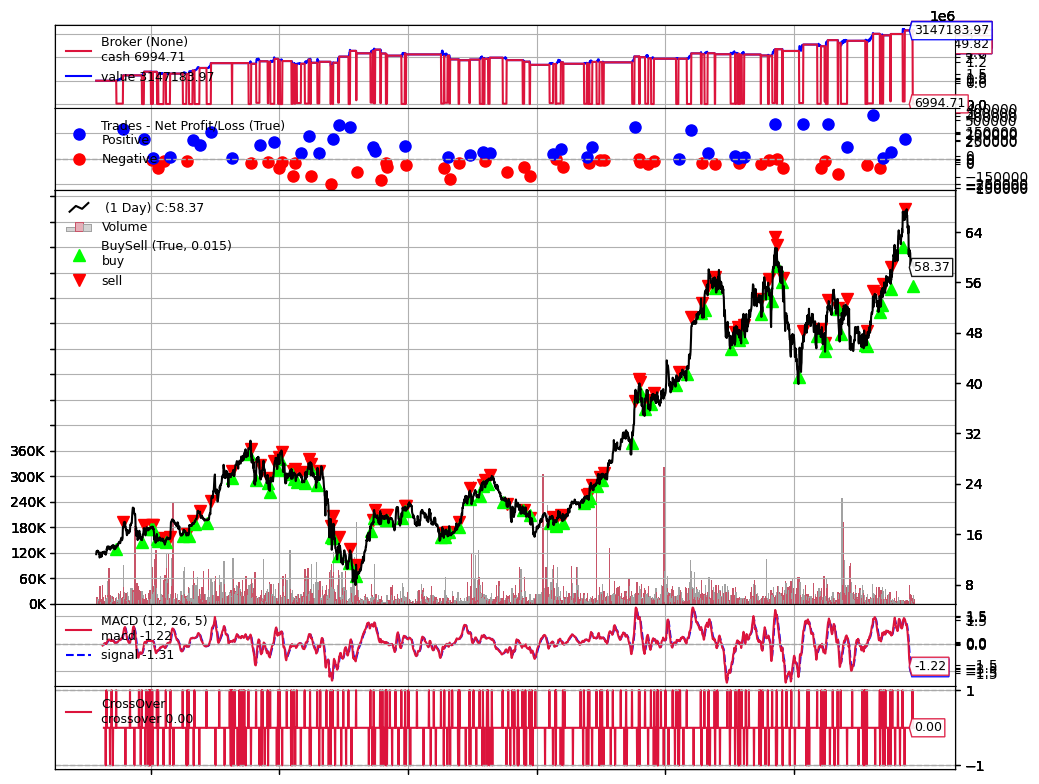

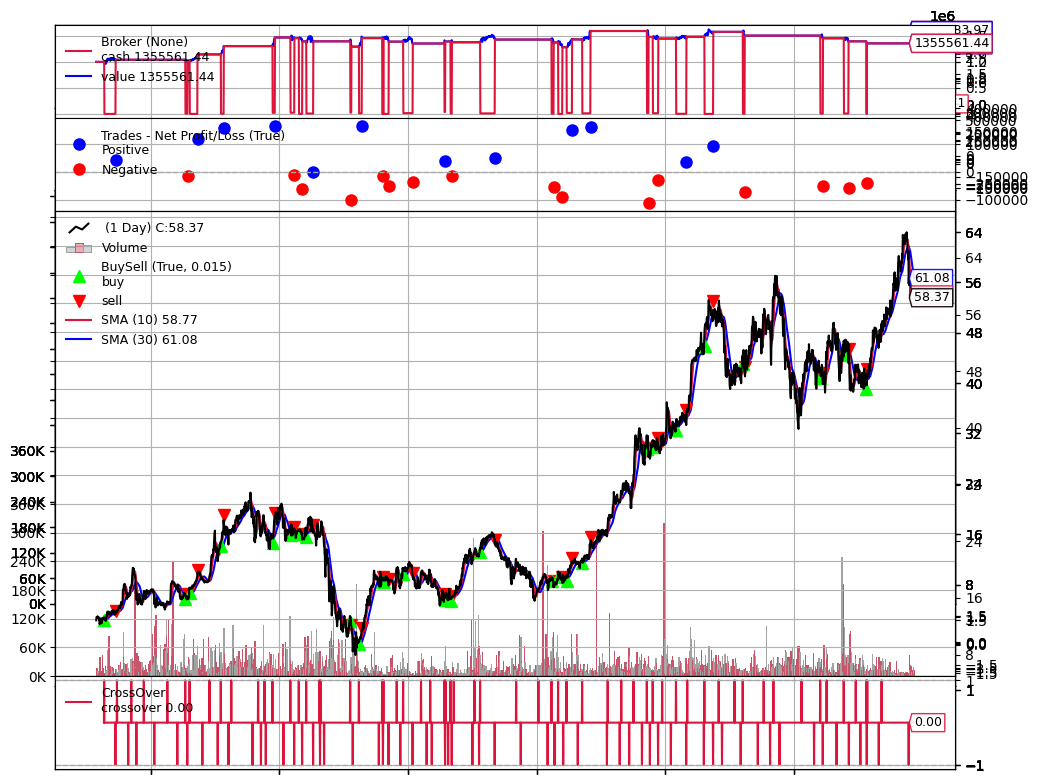

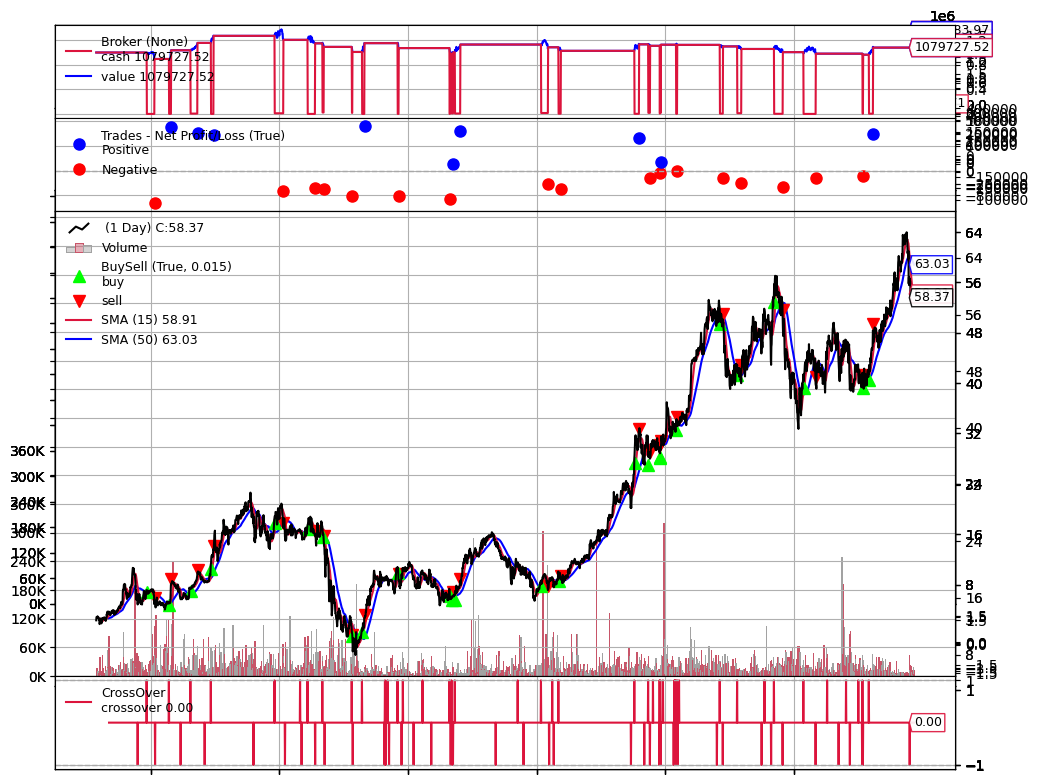

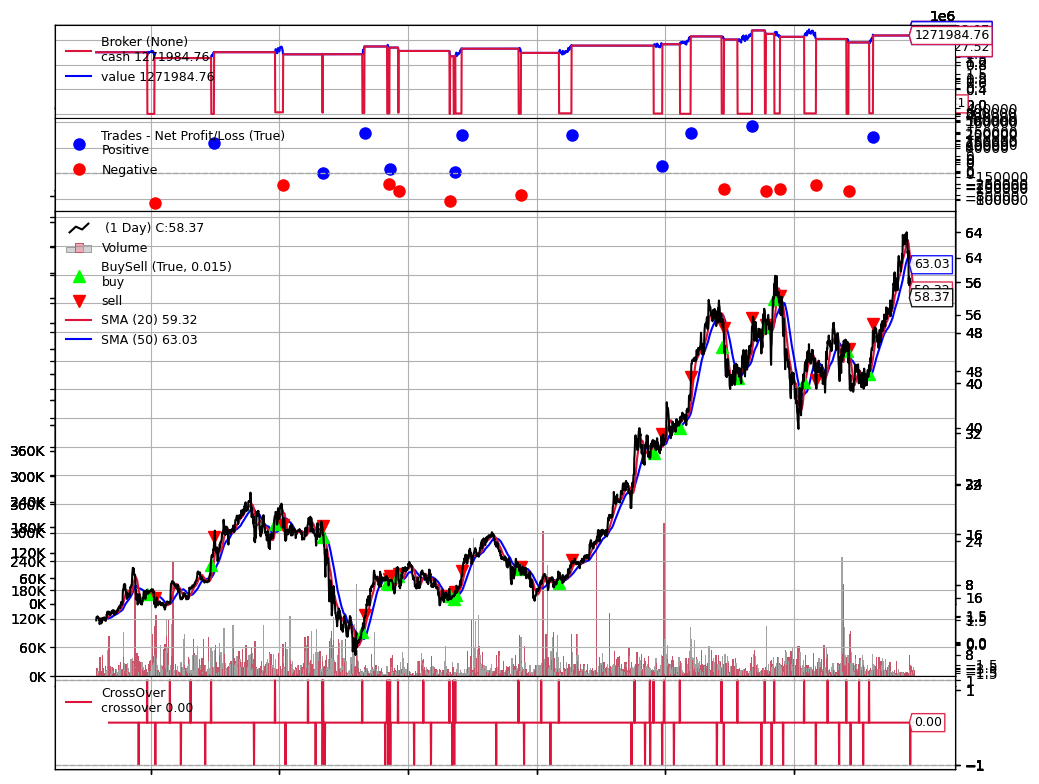

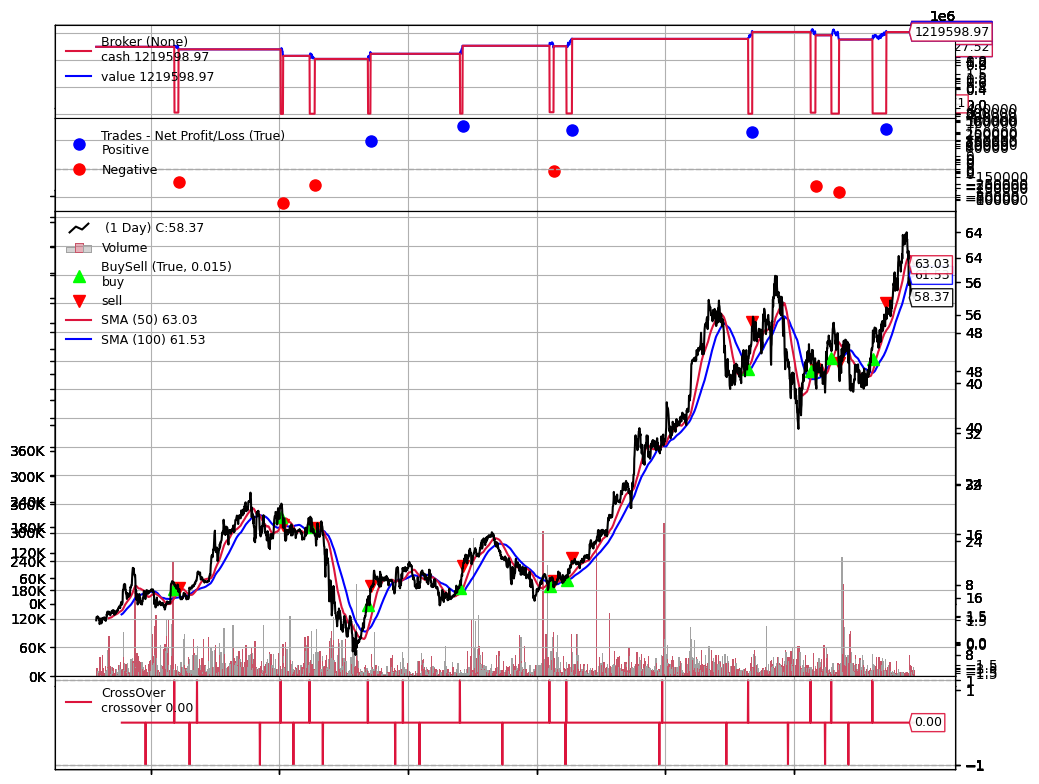

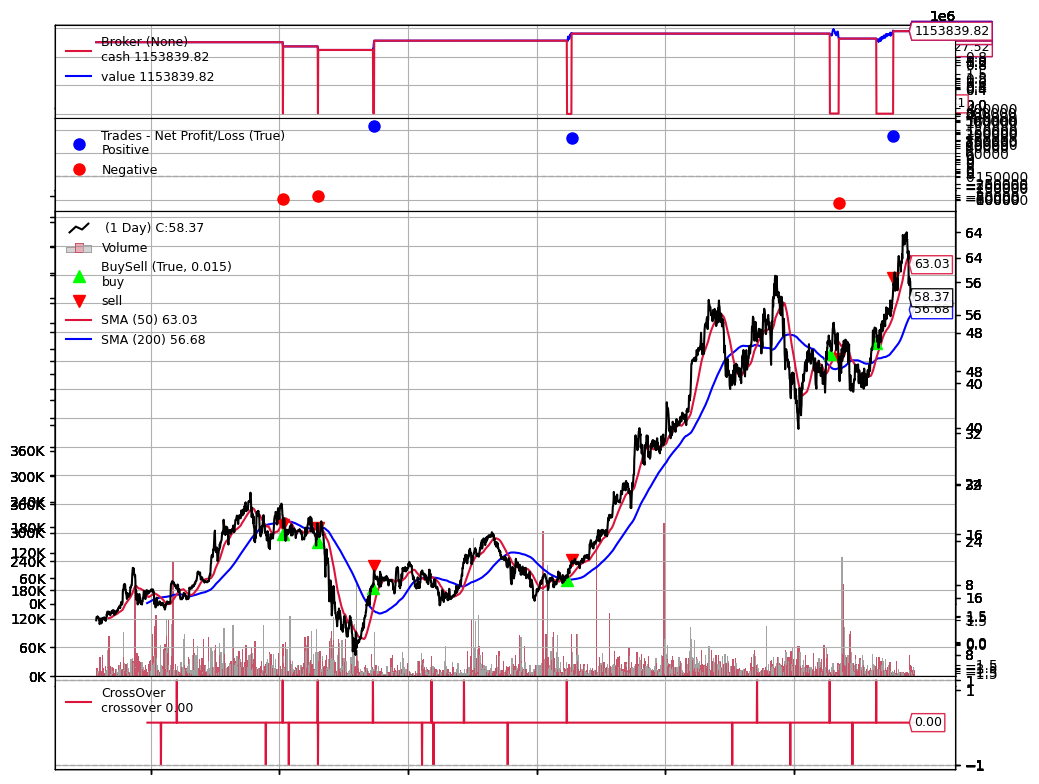

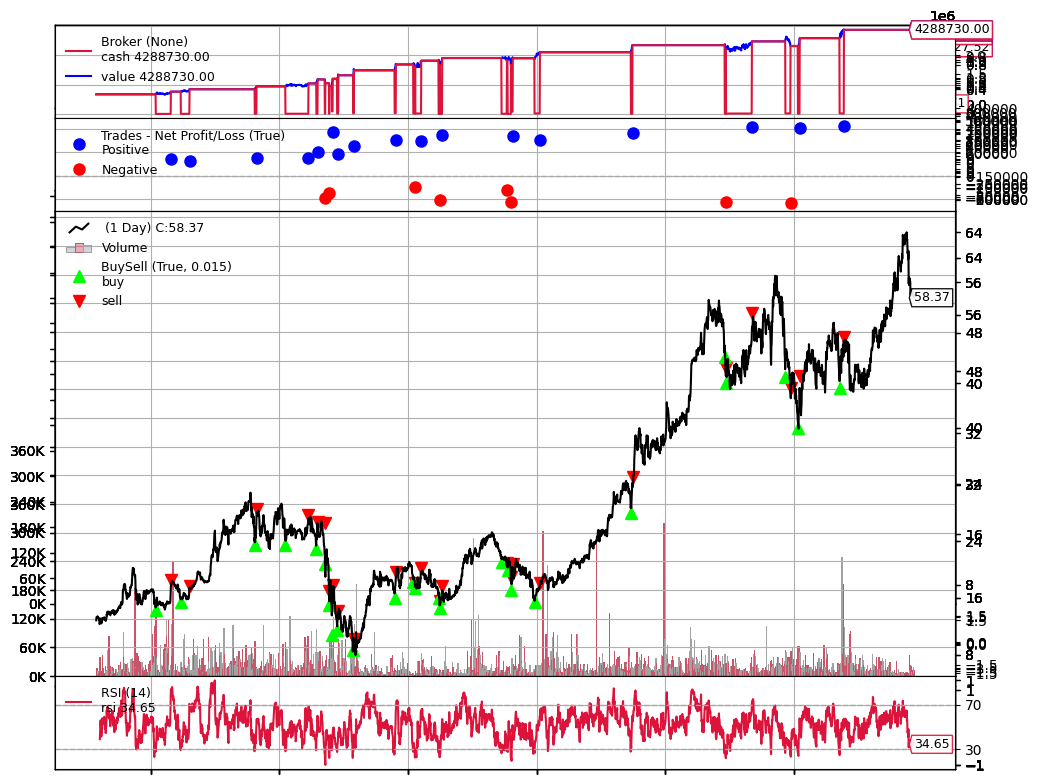

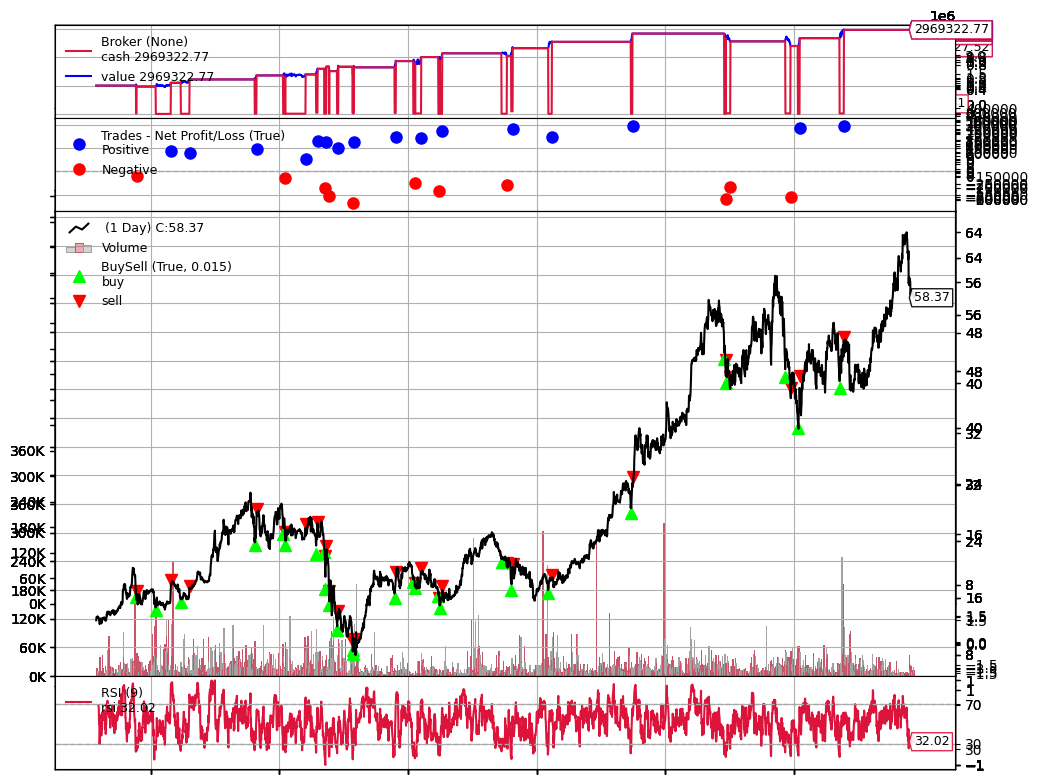

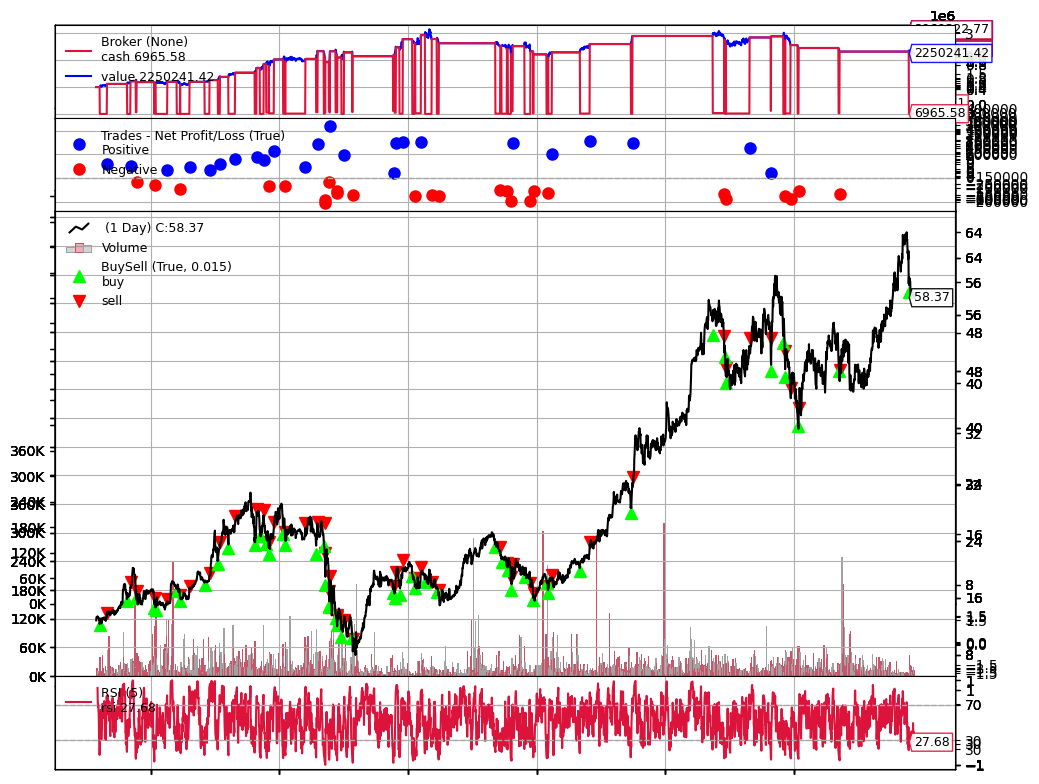

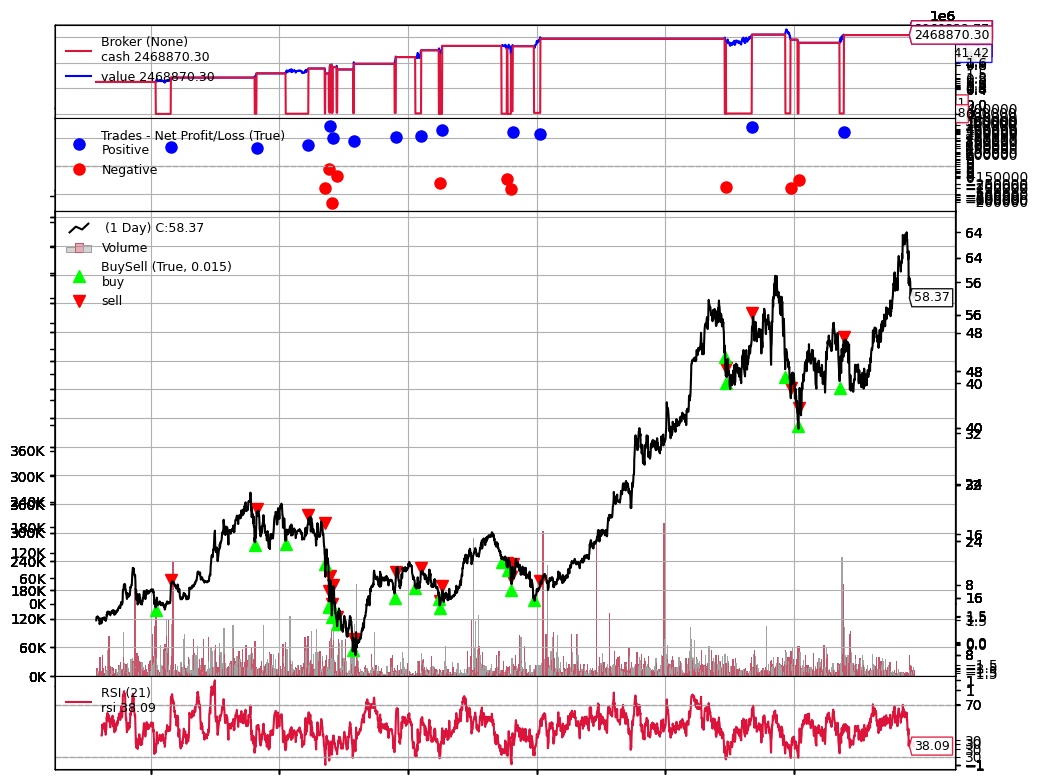

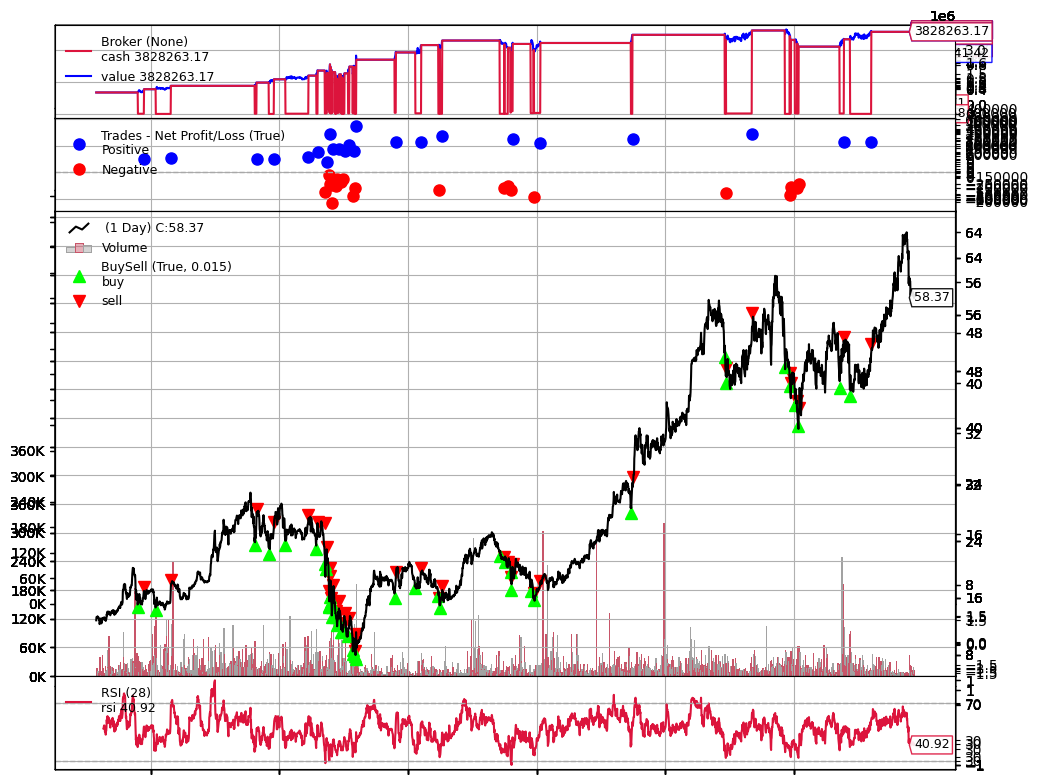

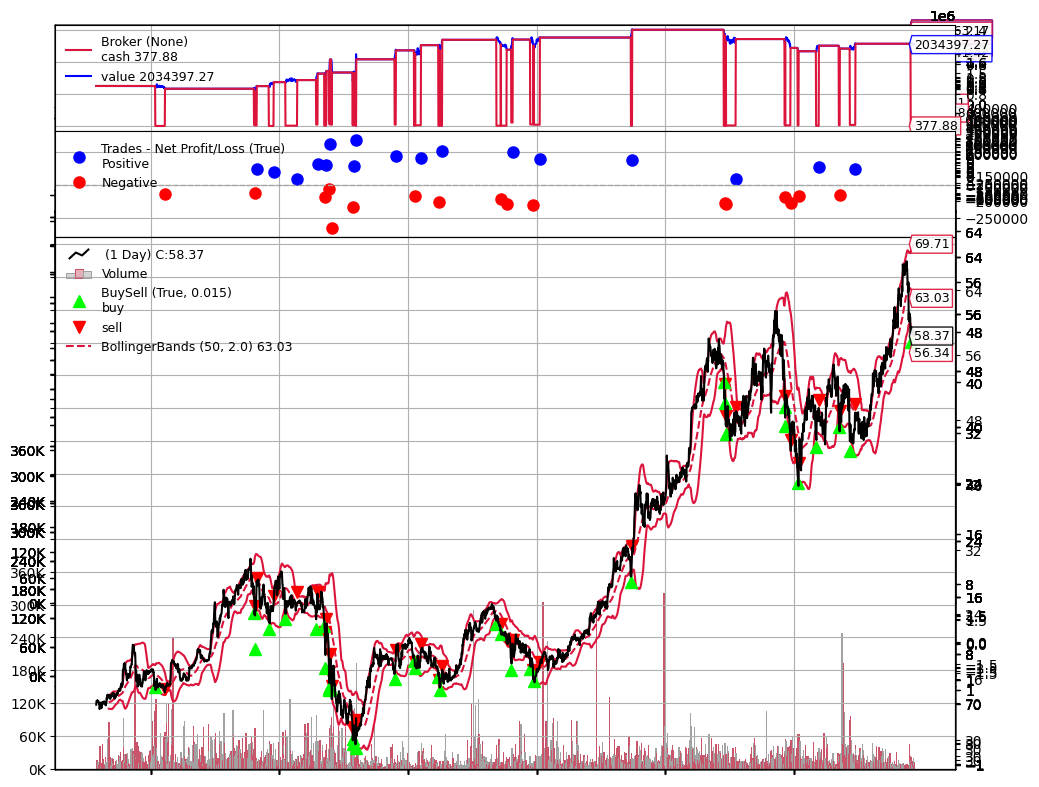

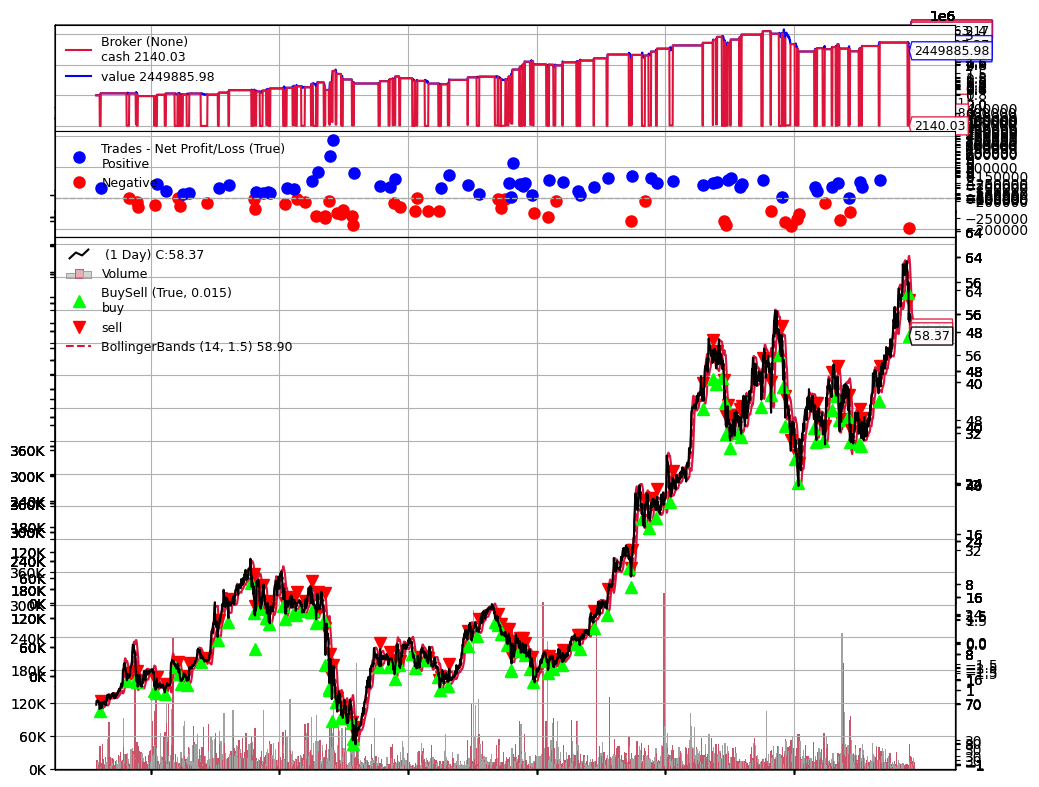

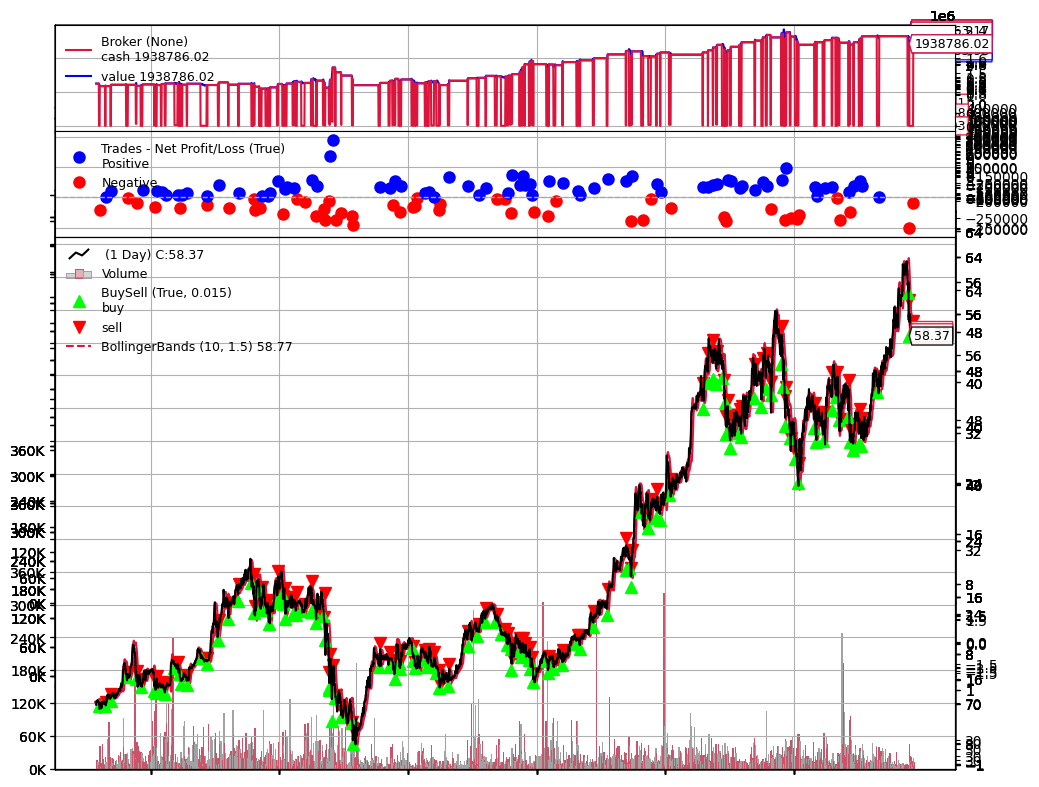

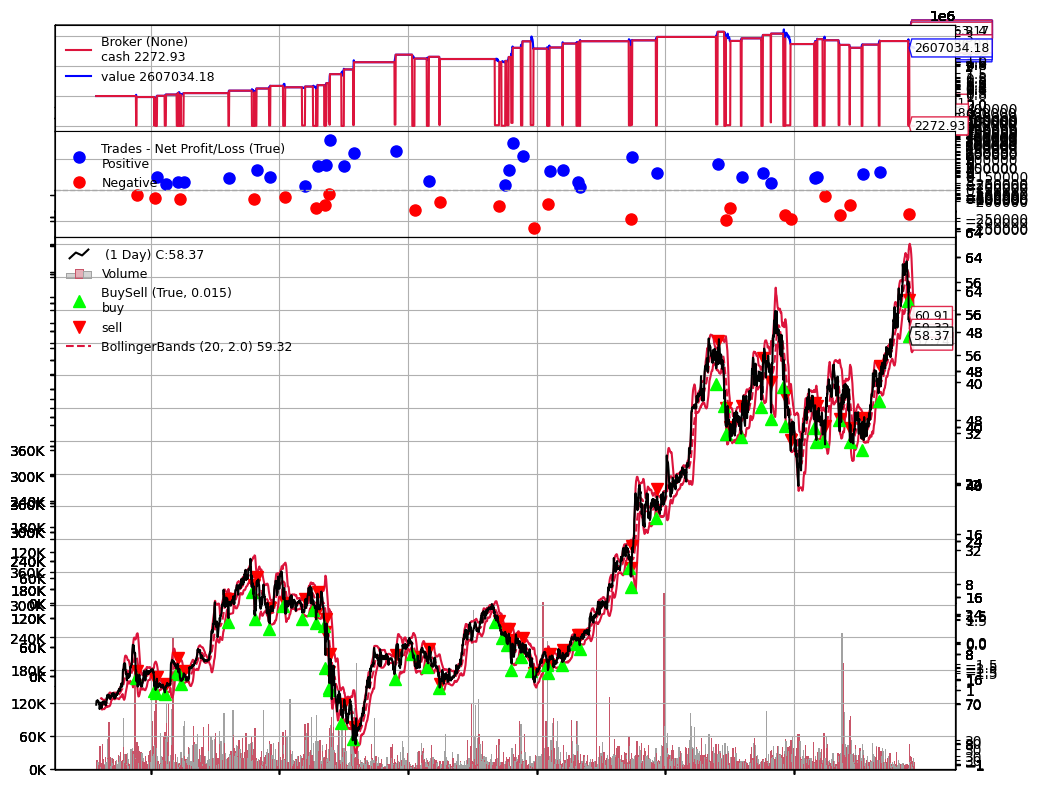

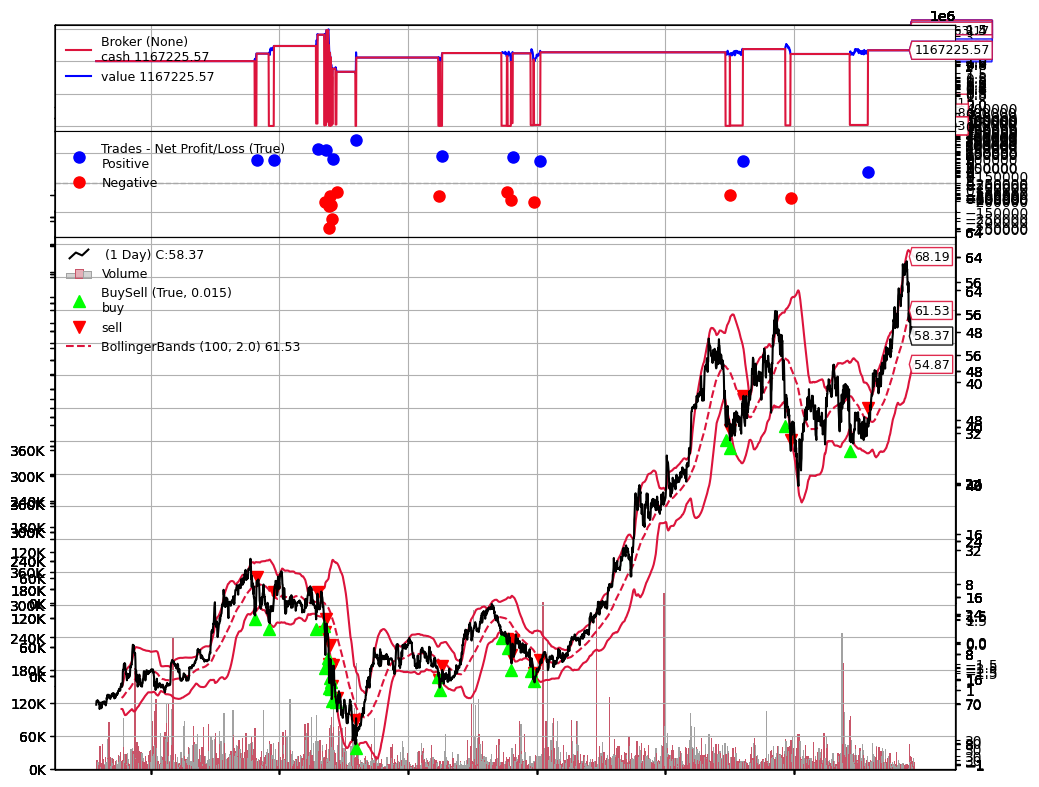

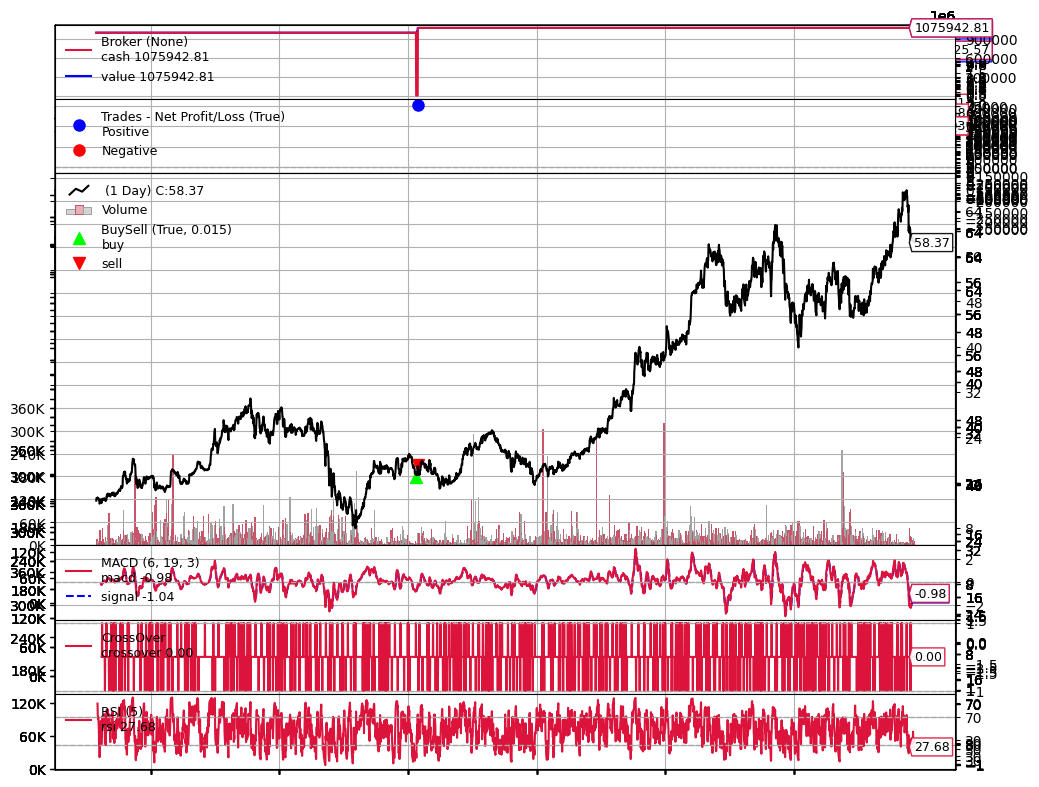

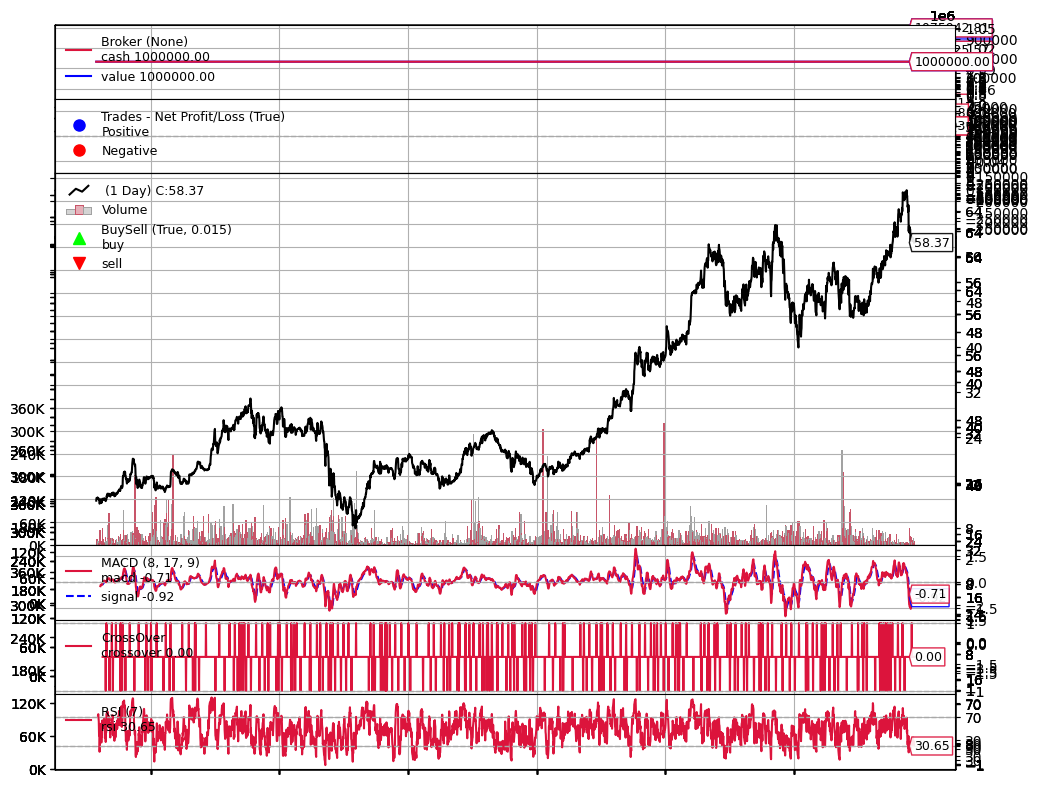

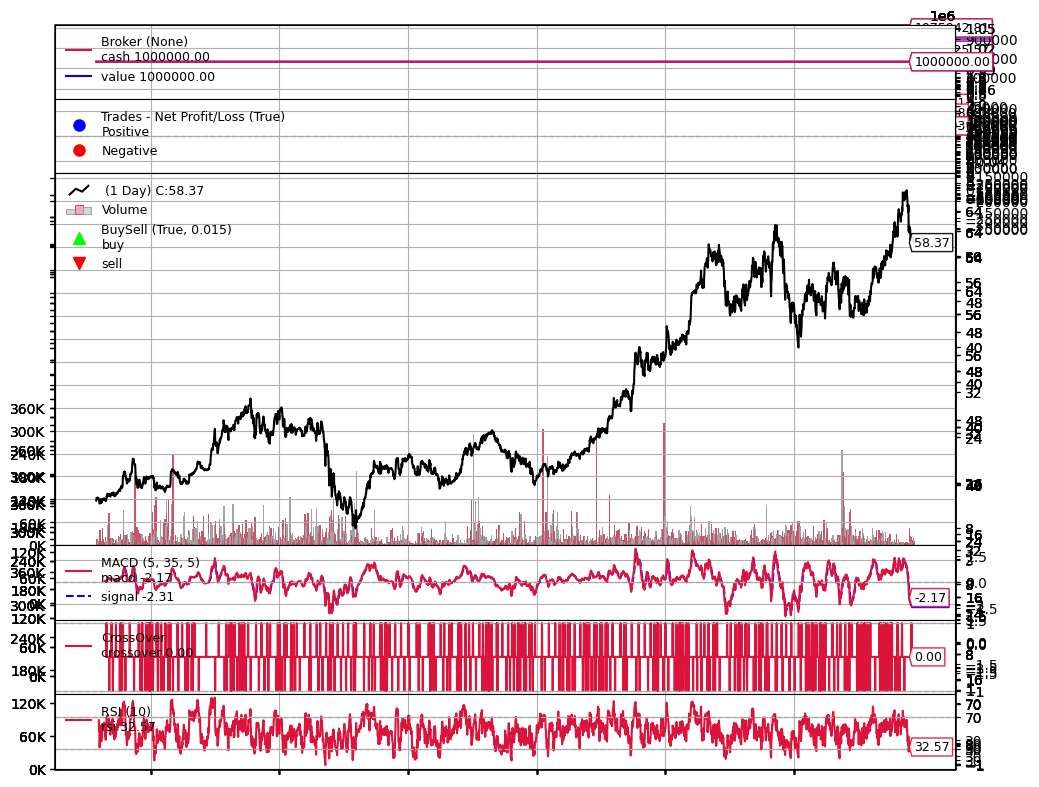

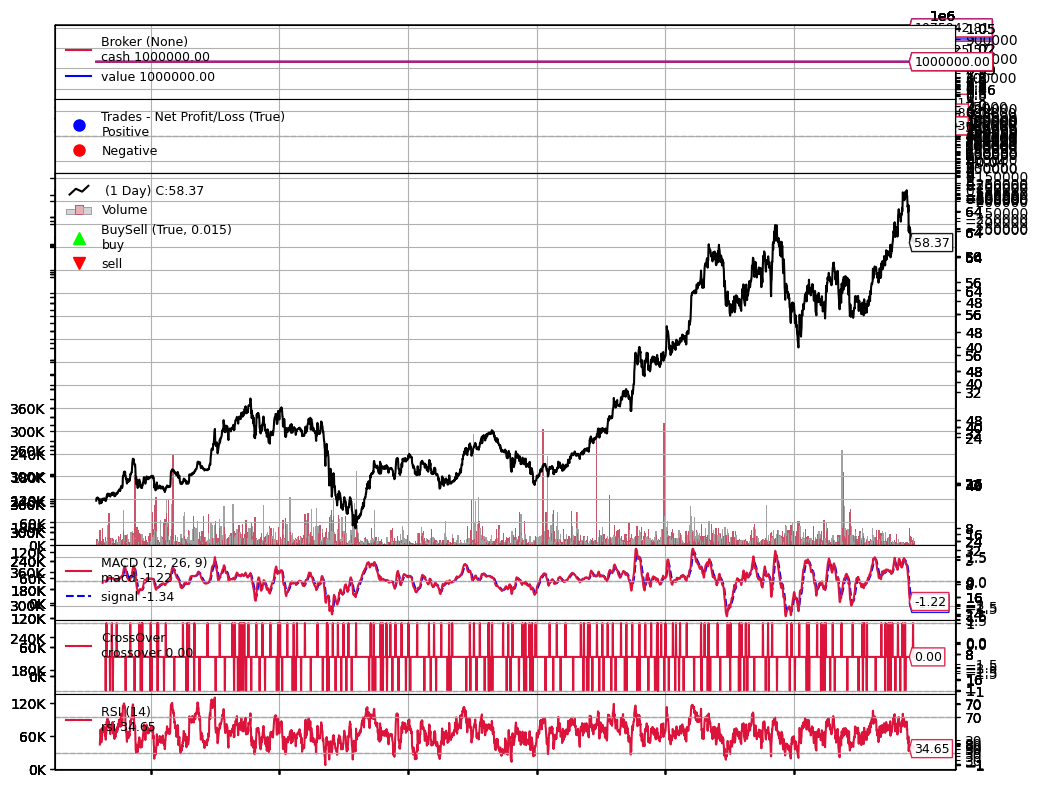

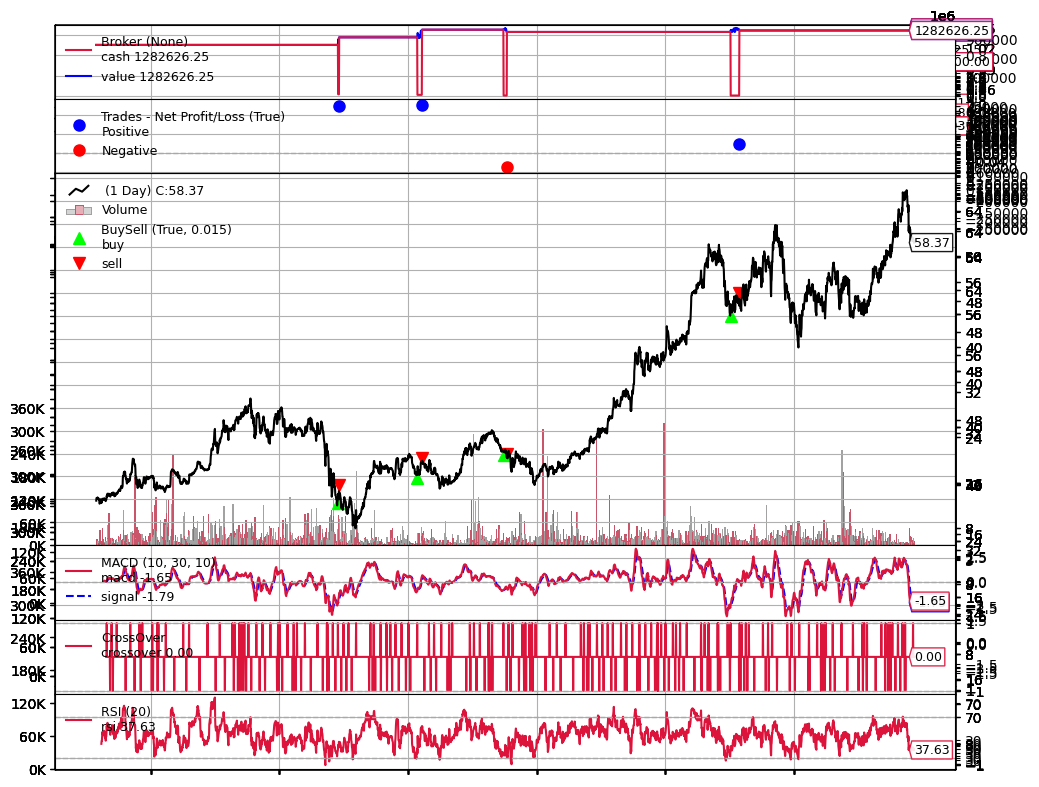

In [ ]:
class AllInSizer(bt.Sizer):
    def _getsizing(self, comminfo, cash, data, isbuy):
        if isbuy:
            size = int(cash / data.close[0])
        else:
            size = self.broker.getposition(data).size
        return size

class ResetMixin():
    def _reset_trade_vars(self):
        self.buy_price = None
        self.take_profit_price = None
        self.stop_loss_price = None

class CrossoverMixin():
    def crossover_next(self):
        price = self.data.close[0]

        if not self.position:
            if self.crossover > 0:
                self.buy()
                self.buy_price = price
                self.take_profit_price = price * (1 + TAKE_PROFIT_PCT)
                self.stop_loss_price = price * (1 - STOP_LOSS_PCT)
        else:
            if price >= self.take_profit_price:
                self.sell()
                self._reset_trade_vars()
                return

            if price <= self.stop_loss_price:
                self.sell()
                self._reset_trade_vars()
                return

            if self.crossover < 0:
                self.sell()
                self._reset_trade_vars()

class MACDStrategy(bt.Strategy, CrossoverMixin, ResetMixin):
    def __init__(self, param):
        macd = bt.ind.MACD(
            self.data.close,
            period_me1=param[0],
            period_me2=param[1],
            period_signal=param[2]
        )
        self.macd = macd.macd
        self.signal = macd.signal
        self.crossover = bt.ind.CrossOver(self.macd, self.signal)
        self._reset_trade_vars()
    
    def next(self):
        super().crossover_next()

class SmaCrossStrategy(bt.Strategy, CrossoverMixin, ResetMixin):
    def __init__(self, param):
        sma1 = bt.ind.SMA(period=param[0])
        sma2 = bt.ind.SMA(period=param[1])
        self.crossover = bt.ind.CrossOver(sma1, sma2)
        self._reset_trade_vars()

    def next(self):
        super().crossover_next()

class RSIStrategy(bt.Strategy, ResetMixin):
    def __init__(self, param):
        self.rsi = bt.ind.RSI(period=param[0])
        self.param = param
        self._reset_trade_vars()
    
    def next(self):
        price = self.data.close[0]

        if not self.position:
            if self.rsi < self.param[1]:
                self.buy()
                self.buy_price = price
                self.take_profit_price = price * (1 + TAKE_PROFIT_PCT)
                self.stop_loss_price = price * (1 - STOP_LOSS_PCT)
        else:
            if price >= self.take_profit_price:
                self.sell()
                self._reset_trade_vars()
                return

            if price <= self.stop_loss_price:
                self.sell()
                self._reset_trade_vars()
                return

            if self.rsi > self.param[2]:
                self.sell()
                self._reset_trade_vars()

class BBStrategy(bt.Strategy, ResetMixin):
    def __init__(self, param):
        self.bb = bt.ind.BollingerBands(
            period=param[0],
            devfactor=param[1]
        )
        self._reset_trade_vars()

    def next(self):
        price = self.data.close[0]

        if not self.position:
            if price < self.bb.lines.bot[0]:
                self.buy()
                self.buy_price = price
                self.take_profit_price = self.buy_price * (1 + TAKE_PROFIT_PCT)
                self.stop_loss_price = self.buy_price * (1 - STOP_LOSS_PCT)
        else:
            if price >= self.take_profit_price:
                self.sell()
                self._reset_trade_vars()
                return

            if price <= self.stop_loss_price:
                self.sell()
                self._reset_trade_vars()
                return

            if price > self.bb.lines.mid[0]:
                self.sell()
                self._reset_trade_vars()

class MACD_RSI_Strategy(bt.Strategy, ResetMixin):
    def __init__(self, param):
        macd = bt.ind.MACD(
            self.data.close,
            period_me1=param[0],
            period_me2=param[1],
            period_signal=param[2]
        )
        self.macd = macd.macd
        self.macd_signal = macd.signal
        self.crossover = bt.ind.CrossOver(self.macd, self.macd_signal)
        self.rsi = bt.ind.RSI(self.data.close, period=param[3])
        self.param = param
        self._reset_trade_vars()

    def next(self):
        if not self.position:
            if self.crossover > 0 and self.rsi < self.param[4]:
                self.buy_price = self.data.close[0]
                self.take_profit_price = self.buy_price * (1 + TAKE_PROFIT_PCT)
                self.buy()
        else:
            if self.data.close[0] < self.buy_price * (1 - STOP_LOSS_PCT):
                self.close()
                self._reset_trade_vars()
                return

            if self.data.close[0] >= self.take_profit_price:
                self.close()
                self._reset_trade_vars()
                return

            if self.crossover < 0 or self.rsi > self.param[5]:
                self.close()
                self._reset_trade_vars()

class BuyAndHoldStrategy(bt.Strategy):
    def __init__(self):
        self.bought = False 

    def next(self):
        if not self.bought:
            cash = self.broker.get_cash()
            price = self.data.close[0]
            size = int(cash / price)
            if size > 0:
                self.buy(size=size)
                self.bought = True

def run_backtest():
    perf_table = {}
    backtest_options = {
        'macd': {
            'params': [
                (5, 35, 5),
                (8, 17, 9),
                (3, 10, 16),
                (19, 39, 9),
                (12, 26, 5)
            ],
            'class': MACDStrategy
        },
        'sma_cross': {
            'params': [
                (10, 30),
                (15, 50),
                (20, 50),
                (50, 100),
                (50, 200)
            ],
            'class': SmaCrossStrategy
        },
        'rsi': {
            'params': [
                (14, 30, 70),
                (9, 25, 75),
                (5, 20, 80),
                (21, 35, 65),
                (28, 40, 60)
            ],
            'class': RSIStrategy
        },
        'bollinger_bands': {
            'params': {
                (20, 2.0),
                (10, 1.5),
                (14, 1.5),
                (50, 2.0),
                (100, 2.0)
            },
            'class': BBStrategy
        },
        'macd_rsi': {
            'params': {
                (12, 26, 9, 14, 30, 70),
                (5, 35, 5, 10, 25, 75),
                (8, 17, 9, 7, 20, 80),
                (10, 30, 10, 20, 40, 60),
                (6, 19, 3, 5, 28, 72)
            },
            'class': MACD_RSI_Strategy
        }
    }

    for stock in stock_dfs[:1]:
        try:
            for v in backtest_options.values():
                for param in v['params']:
                    cerebro = bt.Cerebro()
                    data = bt.feeds.PandasData(dataname=stock)

                    cerebro.adddata(data)
                    cerebro.addstrategy(v['class'], param)
                    cerebro.broker.set_cash(10 ** 6) 
                    #cerebro.broker.set_commission(commission=0.001, margin=1.0, mult=1.0)  
                    cerebro.addsizer(AllInSizer)

                    cerebro.run()
                    #print(cerebro.broker.get_cash())
                    #print(cerebro.broker.get_value())
                    figs = cerebro.plot(figsize=(10, 8))
                    fig = figs[0][0]  
                    display.display(fig)  
            cerebro = bt.Cerebro()
            data = bt.feeds.PandasData(dataname=stock)
            cerebro.adddata(data)
            cerebro.addstrategy(BuyAndHoldStrategy)
            cerebro.broker.set_cash(10 ** 6) 
            cerebro.addsizer(AllInSizer)
            cerebro.run()
            #print("buy and hold:", cerebro.broker.get_value(), cerebro.broker.get_cash())
        except Exception as e:
            # print(e)
            pass

run_backtest()